# 1. Load Data

In [ ]:
import random
random.seed(8)
# Import libraries
!pip install pandas matplotlib statsmodels pmdarima keras tensorflow
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pmdarima as pm
import math
import os
import warnings
warnings.filterwarnings('ignore')

from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_arch
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

import tensorflow as tf
from sklearn.metrics import r2_score
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False # to hide warnings during training stage


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import dataset
data = pd.read_csv('/content/drive/MyDrive/[H4TF Miền Bắc 2024] Workspace/HPG Historical Data.csv')

# 2. EDA

The HPG stock price data set includes 7 data fields, detailed below:

| Feature               | Data Type | Description                                                      |
|:----------------------|:----------|:-----------------------------------------------------------------|
| Date                    | datetime       | Day records price                                |
| Price         | float     | Close price of stock                                  |
| Open        | float    | Open price of stock                                 |
| High                | float     | Highest price on the recording day the stock                                         |
| Low     | object    | Lowest price on the recording day the stock                                             |
| Vol.               | object     | The volume of HPG stocks exchanged on the day is recorded in million stocks                                           |
| % Change                | float     | Change in a stock's closing price compared to the previous day, expressed as a percentage                                     |

In [ ]:
# Check the first 5 rows of the data set
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,03/31/2023,"18,909.0","18,909.0","19,000.0","18,500.0",26.15M,0.00%
1,03/30/2023,"18,909.0","19,091.0","19,227.0","18,864.0",23.05M,0.00%
2,03/29/2023,"18,909.0","18,818.0","19,182.0","18,818.0",19.74M,0.48%
3,03/28/2023,"18,818.0","19,000.0","19,091.0","18,818.0",13.56M,-0.48%
4,03/27/2023,"18,909.0","18,545.0","19,000.0","18,500.0",22.29M,1.96%


In [ ]:
# Check the data type of data fields
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1308 non-null   object
 1   Price     1308 non-null   object
 2   Open      1308 non-null   object
 3   High      1308 non-null   object
 4   Low       1308 non-null   object
 5   Vol.      1308 non-null   object
 6   Change %  1308 non-null   object
dtypes: object(7)
memory usage: 71.7+ KB


However, at the time the data is imported into the ipynb file, the data fields still have the datatype object. Therefore, the team will clean the data before proceeding with further processing.

## 2.1. Cleaning Data

The data cleaning process includes converting the datatype of the columns to the appropriate types.

In [ ]:
# Change the data fields to the appropriate datatype
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = data['Price'].str.replace(',', '').astype(float)
data['Open'] = data['Open'].str.replace(',', '').astype(float)
data['High'] = data['High'].str.replace(',', '').astype(float)
data['Low'] = data['Low'].str.replace(',', '').astype(float)

In [ ]:
# Convert datatype of Vol. to float by removing "M" and multiplying by 10^6 to get the correct units
data['Vol.'] = data['Vol.'].str.replace('M', '').astype(float)
data['Vol.'] = data['Vol.']*1000000

In [ ]:
# Convert the datatype of the Change % column to float by removing the "%" sign.
data['Change %'] = data['Change %'].str.replace('%', '').astype(float)
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-03-31,18909.0,18909.0,19000.0,18500.0,26150000.0,0.00
1,2023-03-30,18909.0,19091.0,19227.0,18864.0,23050000.0,0.00
2,2023-03-29,18909.0,18818.0,19182.0,18818.0,19740000.0,0.48
3,2023-03-28,18818.0,19000.0,19091.0,18818.0,13560000.0,-0.48
4,2023-03-27,18909.0,18545.0,19000.0,18500.0,22290000.0,1.96


In [ ]:
# Check datatype after changing
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1308 non-null   datetime64[ns]
 1   Price     1308 non-null   float64       
 2   Open      1308 non-null   float64       
 3   High      1308 non-null   float64       
 4   Low       1308 non-null   float64       
 5   Vol.      1308 non-null   float64       
 6   Change %  1308 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 71.7 KB


## 2.2. Exploring Dataset and Explaination

### 2.2.1. Check the quality of the dataset

The HPG stock price dataset does not include null values, does not possess duplicate values, and the date column is completely unique. From there, in terms of quality, the data set has no problem.

In [ ]:
# Check the number of rows and columns of the data set
data.shape

(1308, 7)

In [ ]:
# Check the number of null observations
print(data.isnull().sum())

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64


In [ ]:
# Check the number of duplicate observations
print("Số quan sát trùng lặp: " + data.duplicated().sum().astype(str))

Số quan sát trùng lặp: 0


In [ ]:
# Check the number of unique values ​​of each data field
data.nunique()

Date        1308
Price        808
Open         772
High         803
Low          795
Vol.        1140
Change %     650
dtype: int64

### 2.2.2. Check the fields in the dataset

####2.2.2.1. Descriptive Analysis


- Descriptive Statistics data fields in a data set


In [ ]:
data.describe()

,Date,Price,Open,High,Low,Vol.,Change %
count,1308,1308.000000,1308.000000,1308.000000,1308.000000,1.308000e+03,1308.000000
mean,2020-08-18 12:58:20.917431296,19249.098318,19261.464985,19541.894801,18986.827905,2.425365e+07,0.064274
min,2018-01-02 00:00:00,7411.800000,7000.000000,7640.600000,6977.200000,3.320000e+06,-7.000000
25%,2019-05-05 06:00:00,11605.100000,11613.900000,11736.650000,11445.475000,1.319250e+07,-1.132500
50%,2020-08-18 12:00:00,14957.300000,14944.750000,15183.600000,14719.000000,2.102500e+07,0.000000
75%,2021-12-06 06:00:00,24003.825000,24081.000000,24339.325000,23621.425000,3.120250e+07,1.222500
max,2023-03-31 00:00:00,43895.800000,43895.800000,44198.500000,43517.400000,1.096200e+08,6.940000
std,NaN,9780.769912,9809.760926,9929.208070,9676.520954,1.502148e+07,2.374579


Examining the dataset, the authors gain insights into the "Price" variable. On average, the stock price of HPG is approximately 19249 VND, with a significant variation indicated by a standard deviation of 9780 VND.

To better understand the price distribution, the authors look at the quartiles. The median price figure is 19249 VND, showing that half of the stock generates below this amount while the other half exceeds it. Notably, there are outliers, with close prices ranging from a minimum of 7411 VND to a maximum of 43895 VND. These extremes may result from specific company circumstances, highlighting the diverse issues that businesses face.


- Determine outlier (if exists) and perform descriptive statistics on observations with outlier values ​​in data fields

In [ ]:
# A statistical function that describes observations that are outliers for each field in a data field
def outlier_detection(data, columns):
    result_df = pd.DataFrame(index=data.describe().index)  # Initialize with the same index as 'data'
    for col in columns:
        IQR = data[col].quantile(0.75) - data[col].quantile(0.25)
        lower_bound = data[col].quantile(0.25) - 1.5 * IQR
        upper_bound = data[col].quantile(0.75) + 1.5 * IQR
        # Finding ourliers
        outlier_condition = (data[col] < lower_bound) | (data[col] > upper_bound)
        outliers = data.loc[outlier_condition, col].describe()
        # Create an additional column for each outlier statistic of the data fields
        result_df[f'outlier_{col}'] = outliers
    return result_df

outlier_detection(data, data.columns)

,outlier_Date,outlier_Price,outlier_Open,outlier_High,outlier_Low,outlier_Vol.,outlier_Change %
count,0,18.000000,14.000000,14.000000,20.00000,4.200000e+01,94.000000
mean,NaT,43159.988889,43371.428571,43739.028571,42669.74500,7.132143e+07,0.247979
min,NaT,42609.200000,42987.600000,43366.000000,41928.10000,5.878000e+07,-7.000000
25%,NaT,42930.825000,43157.925000,43536.325000,42155.10000,6.175000e+07,-6.200000
50%,NaT,43101.150000,43366.000000,43706.550000,42722.75000,6.666500e+07,4.810000
75%,NaT,43290.300000,43555.250000,43952.575000,43025.45000,7.317000e+07,5.990000
max,NaT,43895.800000,43895.800000,44198.500000,43517.40000,1.096200e+08,6.940000
std,NaN,386.604135,285.447512,262.955016,493.30164,1.281941e+07,6.064753


From there we can see that the data fields related to prices have an insignificant number of outliers (from 14-20/1308 observations accounting for 1.07%-1.53%, almost negligible).

However, the team will still process outliers according to each respective model instead of eliminating these outlier observations because that would corrupt the nature of the data set.

### 2.2.3. Explore data fields

#### 2.2.3.1. Explore stock price data fields

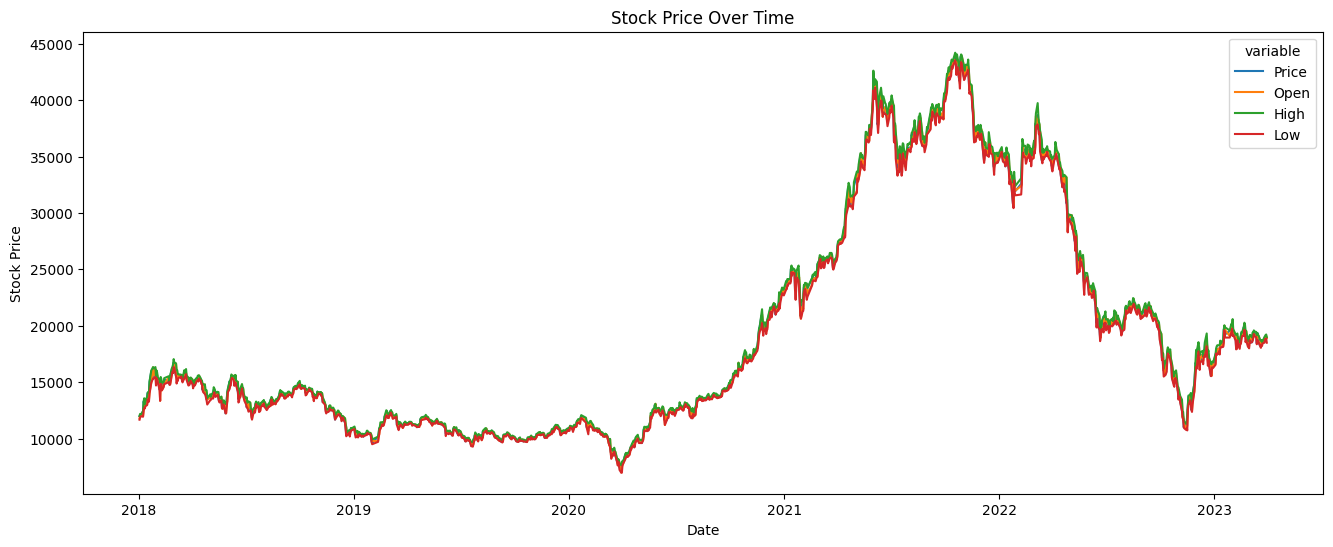

In [ ]:
# A line graph shows the price of a stock over time
dfl = pd.melt(data[['Date', 'Price', 'Open', 'High', 'Low']], ['Date'])

plt.figure(figsize=(16, 6))
sns.lineplot(data = dfl,
             x = 'Date',
             y = 'value',
             hue = 'variable')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()

Based on the chart above, we can see that revenue fluctuated a lot from 2018 to 2023, and there must be many factors affecting this fluctuation. Let's analyze this fluctuation more closely through the analysis of the reasons below and build a model to evaluate and predict the close price of HPG stock.



#### 2.2.3.2. Stock Price Trend Explaination ( Focus on 2022 )
The stock price trend showed that from 2018 to 2020, the price just remained stable under 20 thousand VND but in 2021, the price skyrocketed to nearly 40 thousand VND then dropped strongly through 2022 to 2023. In this report, we focus on 2022 because it is the year that has many important geopolitical events that still affect the steel consumption and HPG stock price this year.

    Q1: Stock prices increased sharply
This is due to the fact that steel consumption in the Vietnamese market as a whole and Hoa Phat in particular only reached its highest level in Q1 and declined in the following three quarters, leading to the highest stock price in Q1. Specifically, in 2022, the Vietnamese real estate market started quite excitedly in early 2022, leading to an increase in demand for construction steel (Hoa Phat 2022 Annual Report).

    Q2: Sudden plunge in stock prices
Stock prices plummeted from March to April due to the escalating tensions of the Russia-Ukraine war. Coal prices skyrocketed due to the geopolitical conflict crisis, coupled with the impact of sluggish consumption and low selling prices caused by weak demand, putting significant pressure on the cost of goods sold. The energy crisis stemming from the Russia-Ukraine war has tripled the price of coking coal, one of the two main raw materials for blast furnace steelmaking, to three times its usual level during the two peak periods of March and May 2022, leading to a rapid decline in stock prices. (Hoa Phat 2022 Annual Report; special.nhandan.vn)

    Q3: Stock prices remained gloomy
The high input material prices in Q2 were reflected in the steel production cost in Q3, leading to a significant increase in the cost of goods in inventory. Inflation and economic recession have weakened global steel demand, consequently affecting domestic demand and prices as well. Additionally, the domestic real estate market has been sluggish due to tightened credit in the sector, contributing to a significant decrease in steel consumption in Vietnam. In the third quarter, the average selling price of construction steel decreased by 3%, HRC (Hot Rolled Coil) by 26%, and products made from HRC, such as steel pipes and iron sheets, decreased by 17% and 20%, respectively, compared to the same period last year. Hòa Phát's consumption volume increased but could not offset the negative impact of selling prices, leading to a decline in revenue (vietnaminsider.com)

    Q4: The stock price continued to drop
The downturn in Vietnam's real estate market in the second half of 2022 caused a decline in domestic steel consumption compared to the same period in the previous year, which made the stock price of HPG continue to drop.


####2.2.3.4: Univariate Analysis

In this section, our group will show the distribution chart of the four continuous variables : Price, Open, High, Low.

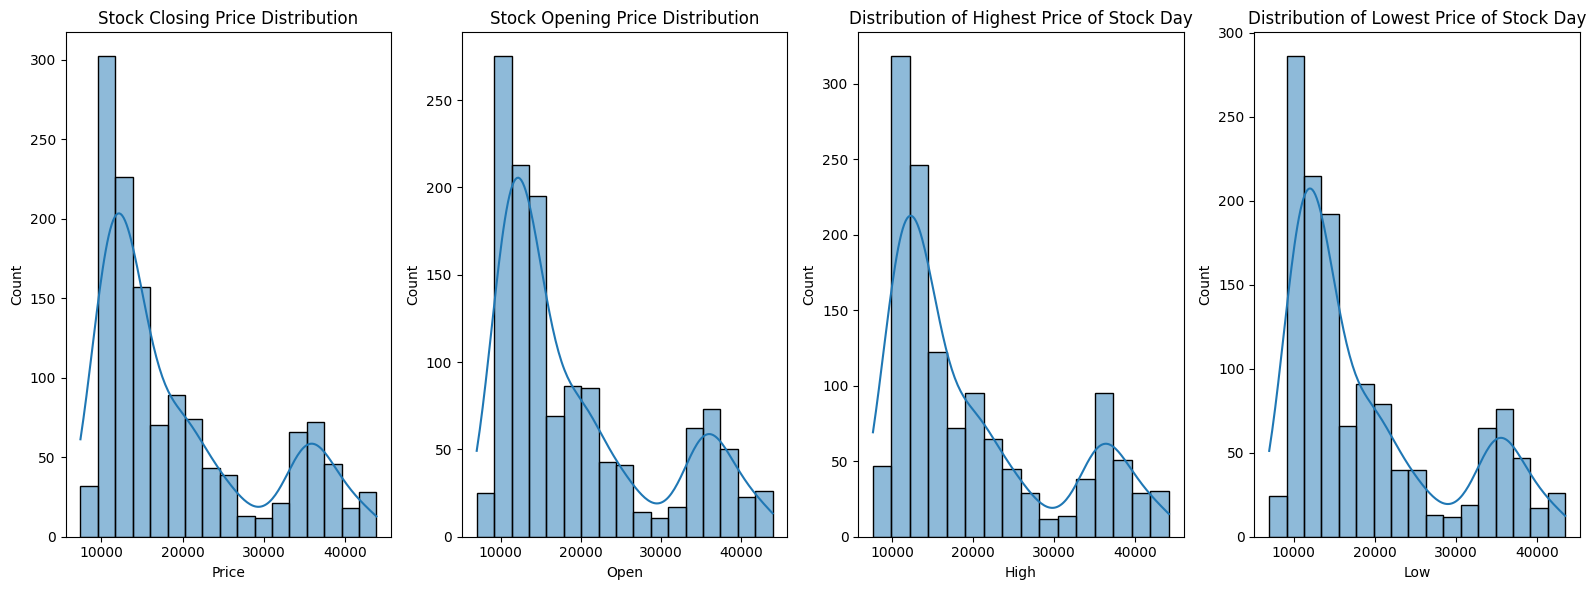

In [ ]:
# Distribution of stock closing prices
fig, axes = plt.subplots(1, 4, figsize = (16,6))

sns.histplot(data['Price'], kde=True, ax = axes[0])
axes[0].set_title('Stock Closing Price Distribution')

sns.histplot(data['Open'], kde=True, ax = axes[1])
axes[1].set_title('Stock Opening Price Distribution')

sns.histplot(data['High'], kde=True, ax = axes[2])
axes[2].set_title('Distribution of Highest Price of Stock Day')

sns.histplot(data['Low'], kde=True, ax = axes[3])
axes[3].set_title('Distribution of Lowest Price of Stock Day')

plt.tight_layout()
plt.show()

Based on the charts above, we can see that the distribution is skewed to the left, so the majority of stock price per day is low around 10000 to 25000 USD; However there are still many days where stock price is at 25000 USD or higher or more, especially many days with stock price of more than 40000 USD. Therefore, the close price distribution is different within the HPG system.

Next our group will analyze the volume of shares exchanged by day through the line chart below.

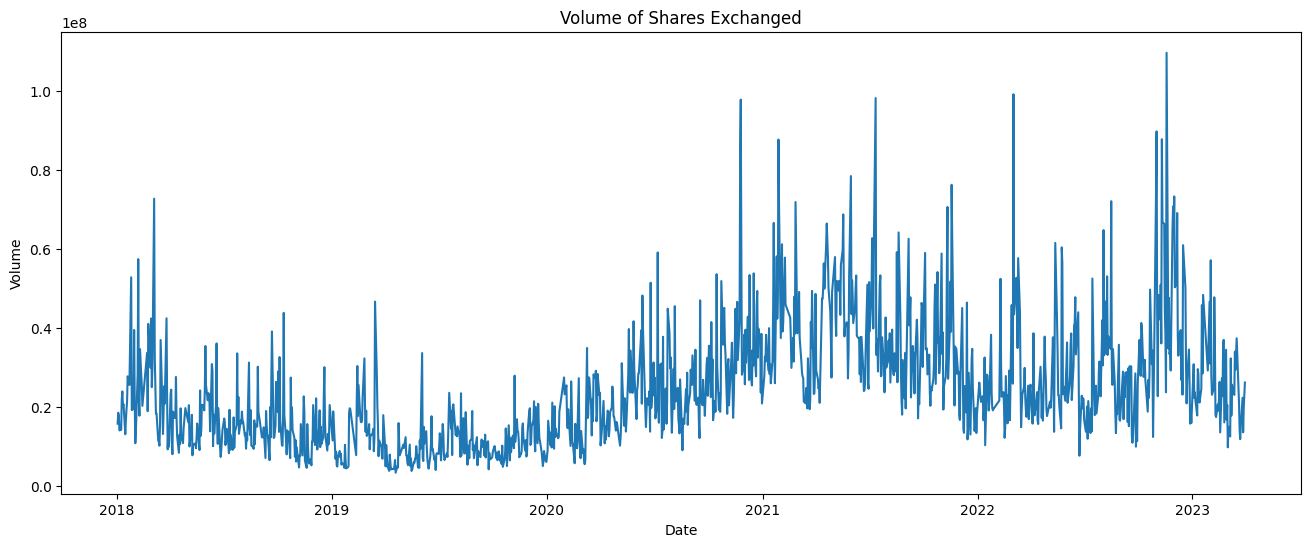

In [ ]:
# Line graph of the volume of shares exchanged by day
plt.figure(figsize=(16, 6))
sns.lineplot(data=data, x='Date', y='Vol.')
plt.title('Volume of Shares Exchanged')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

The line graph above provided shows the trading volume of shares from 2018 to 2023. It displays the fluctuations in trading activity over time, with various peaks indicating periods of high trading volume.

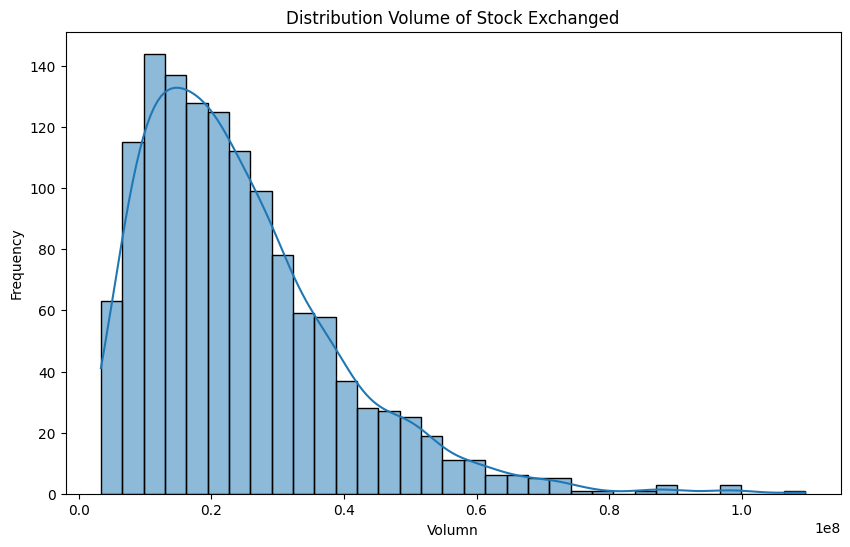

In [ ]:
# Distribution Vol. of HPG stock
plt.figure(figsize=(10, 6))
sns.histplot(data['Vol.'], kde=True)
plt.title('Distribution Volume of Stock Exchanged')
plt.xlabel('Volumn')
plt.ylabel('Frequency')
plt.show()

Based on the histogram provided, it can be seen that the majority of stock trading occurs at low volume, with the highest frequency on the left side of the chart. This suggests that larger transactions are less common. The apparent decrease in frequency as volume increases may indicate that the market is highly liquid at low volume levels but declines as volume increases. This may also reflect the nature of investors participating in the market, with a large number of retail investors and fewer larger or institutional investors.

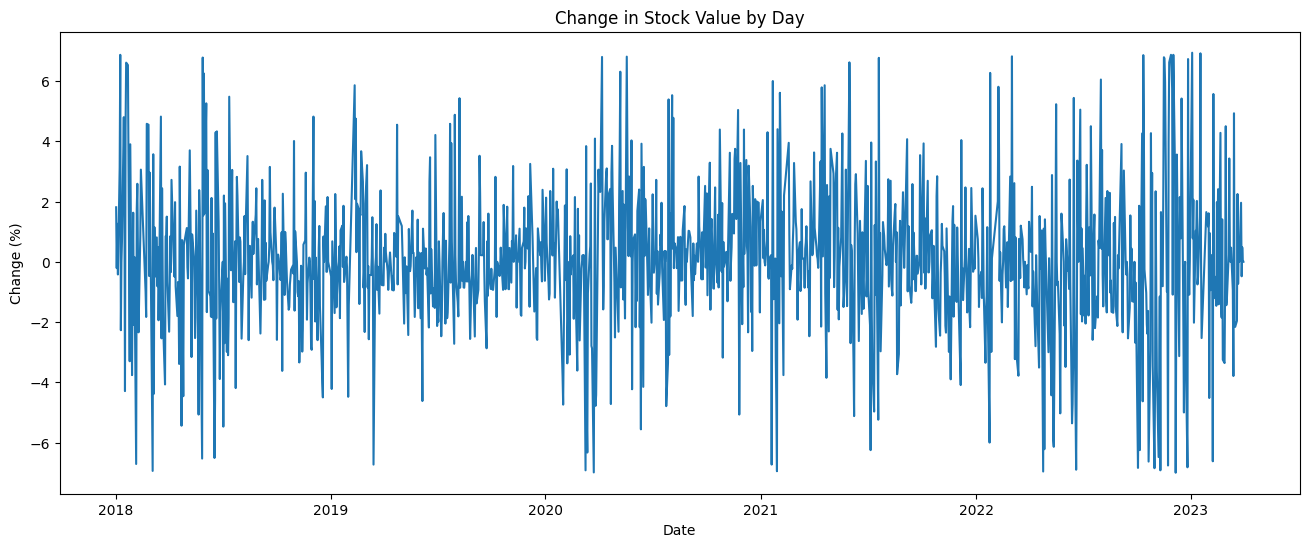

In [ ]:
# Change % line graph of HPG stock by day
plt.figure(figsize=(16, 6))
sns.lineplot(data=data, x='Date', y='Change %')
plt.title('Change in Stock Value by Day')
plt.xlabel('Date')
plt.ylabel('Change (%)')
plt.show()

The chart shows large stock price fluctuations from 2018 to 2023, with value fluctuations ranging from -6% to +6%. There is no clear upward or downward trend over time, but rather unpredictable and seemingly violent fluctuations. This may indicate that the stock has a high level of risk and that price fluctuations can be due to various factors such as news about the company, general market movements, or macroeconomic events.

####2.2.3.4. Bivariate Analysis

<Axes: >

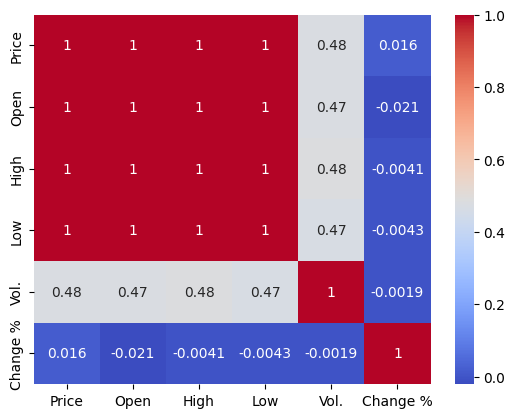

In [ ]:
# Correlation between variables except date
corr = data.drop('Date', axis=1).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')

The relationship between the variables on the heatmap can be understood as follows:

Price and Change %: The correlation coefficient is 0.016, indicating a veryweak relationship between stock price and percentage change. This may indicate that the stock price is not the main factor influencing short-term price changes.

Open and Change %: The correlation coefficient is -0.021, a weak negative relationship. This may indicate that the opening price is not a reliable indicator of intraday price changes.

High and Change %: The correlation coefficient is -0.0041, indicating that there is no clear relationship between the highest price of the day and the price change.

Low and Change %: The correlation coefficient is -0.0043, similar to High and Change %, with no clear relationship.

Overall, the very low correlation coefficients indicate that there is no strong relationship between these variables. In stock analysis, this can be understood to mean that factors such as stock price, opening price, high and low prices do not greatly influence the fluctuation of short-term price change percentage. This may also reflect the difficult forecasting nature of the stock market, where other factors aside.

In [ ]:
#Export to excel file
data.to_excel('/content/drive/MyDrive/[H4TF Miền Bắc 2024] Workspace/Submission/CleanedDataset.xlsx', index=False)

The cleaned dataset is then exported to a separate file for convenience in future usages of our team in model building.

# 3. Model Building and Evalutions

## 3.1. ARIMA

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/[H4TF Miền Bắc 2024] Workspace/Submission/CleanedDataset.xlsx')

We set 'Date' in our dataframe as our main index so we can reduce the number of relevant preprocessing steps for the dataframe later on.

In [ ]:
# Convert 'Date' to datetime and set as index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index(ascending=True)

# Ensure Change % is in the correct format
df['Change %'] = df['Change %'].apply(lambda x: float(str(x).replace(',', '.')))
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2018-01-02,11991.0,11789.9,12003.6,11676.8,15730000.0,1.81
2018-01-03,11965.9,12066.4,12192.1,11890.5,18510000.0,-0.21
2018-01-04,12116.7,12016.2,12167.0,11965.9,17790000.0,1.26
2018-01-05,12066.4,12091.6,12179.6,11978.4,14030000.0,-0.42
2018-01-08,12443.5,11991.0,12443.5,11940.7,14190000.0,3.13


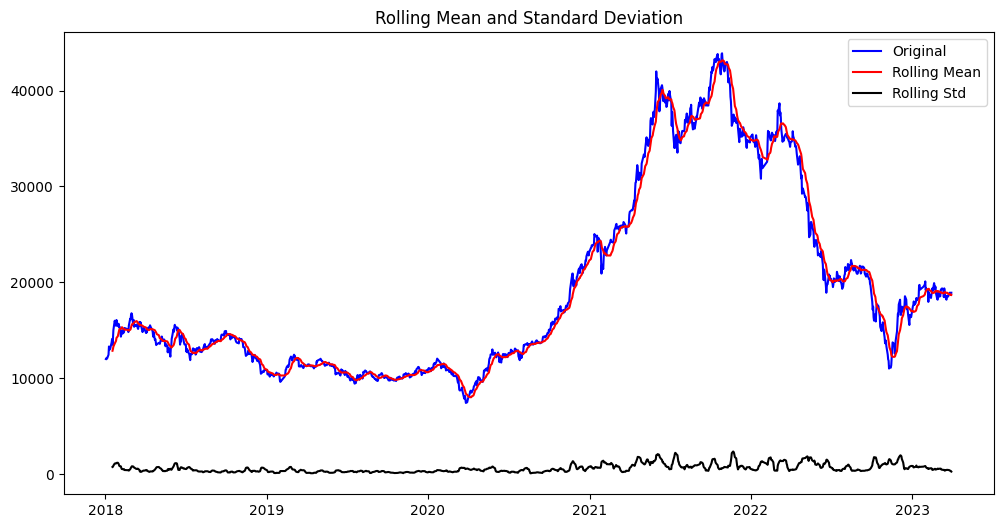

Results of Dickey-Fuller Test:
Test Statistic                   -1.186168
p-value                           0.679518
No. of lags used                 15.000000
Number of observations used    1292.000000
critical value (1%)              -3.435421
critical value (5%)              -2.863780
critical value (10%)             -2.567962
dtype: float64


In [ ]:
# Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(12, 6))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show()

    print("Results of Dickey-Fuller Test:")
    adft = adfuller(timeseries, autolag='AIC')

    # Output for dft will give us without defining what the values are.
    # Hence we manually write what values it explains using a for loop
    output = pd.Series(adft[0:4], index=['Test Statistic', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, value in adft[4].items():
        output['critical value (%s)' % key] = value
    print(output)

# Apply the stationarity test on the 'Price' column
test_stationarity(df['Price'])


The time series data visually exhibits a clear upward trend, indicating that the average stock price increases over time. This non-constant mean is a hallmark of non-stationarity. Further visual inspection reveals changing volatility, with price fluctuations becoming more pronounced in later periods. Statistical analysis using the Dickey-Fuller test confirms this non-stationarity, as the test statistic does not fall within the critical region, and the high p-value indicates a failure to reject the null hypothesis of a unit root. Therefore, both visual and statistical evidence strongly suggest that this stock price data is non-stationary and requires appropriate transformations before applying models like ARIMA.

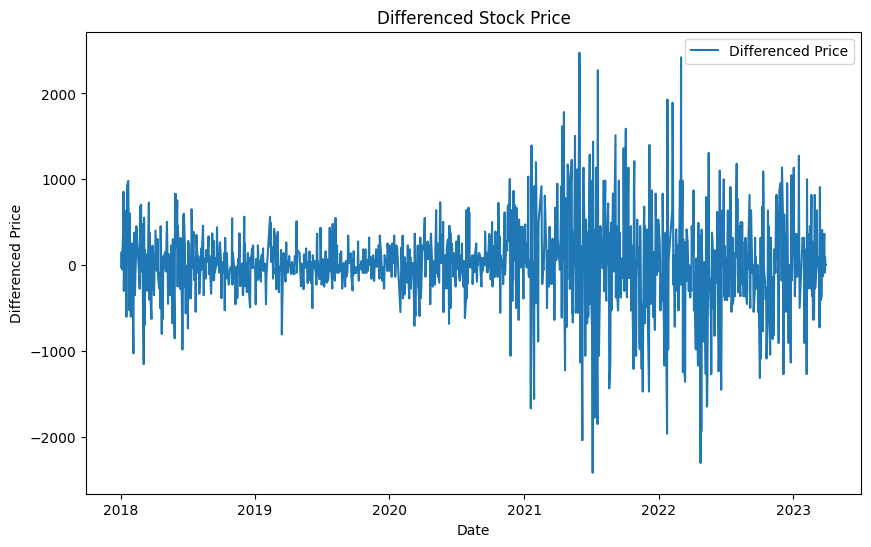

In [ ]:
df['Price_diff'] = df['Price'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(10, 6))
plt.plot(df['Price_diff'], label='Differenced Price')
plt.title('Differenced Stock Price')
plt.xlabel('Date')
plt.ylabel('Differenced Price')
plt.legend()
plt.show()


The price changes oscillate around zero, suggesting a lack of a consistent direction in the stock's movement. While the changes appear largely random, there are periods of increased volatility clustered together, indicating that the stock's price is influenced by underlying market dynamics. A few extreme price changes (outliers) are also noticeable, likely due to significant events impacting the stock. Overall, the plot suggests the differenced stock price might be stationary, making it suitable for modeling with methods that assume stationarity, such as ARIMA.

<Figure size 640x480 with 0 Axes>

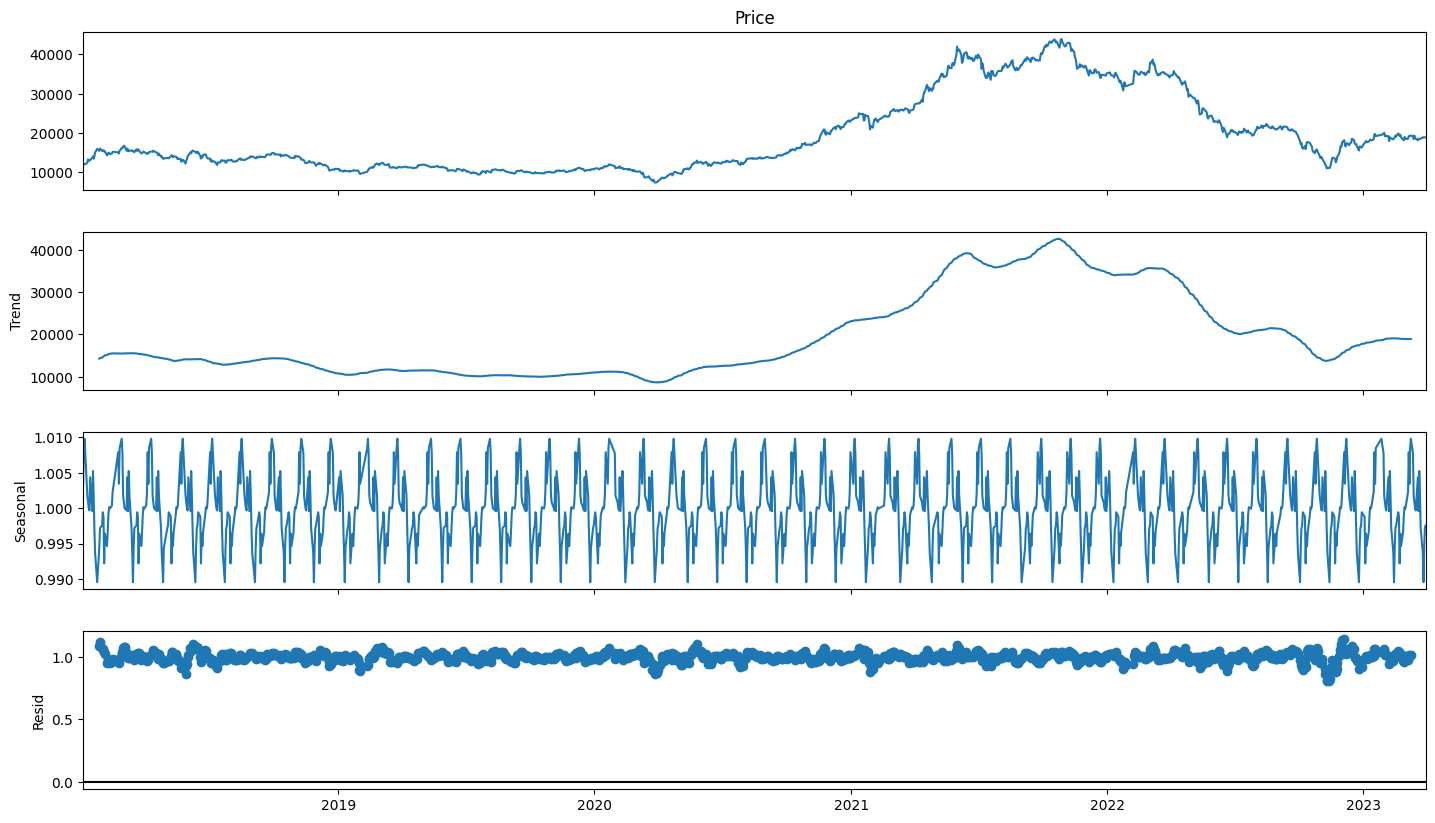

In [ ]:
result = seasonal_decompose(df['Price'], model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

A consistent seasonal pattern, though smaller in scale compared to the overall trend, indicates regular fluctuations that occur within specific time frames, possibly linked to calendar cycles or market events. The residual component, representing noise and unexplained variations, remains relatively minor, suggesting the trend and seasonal components effectively capture most of the price movements. Overall, the decomposition highlights the strong influence of long-term trends and recurring seasonal patterns on stock prices, with a limited impact from random fluctuations.

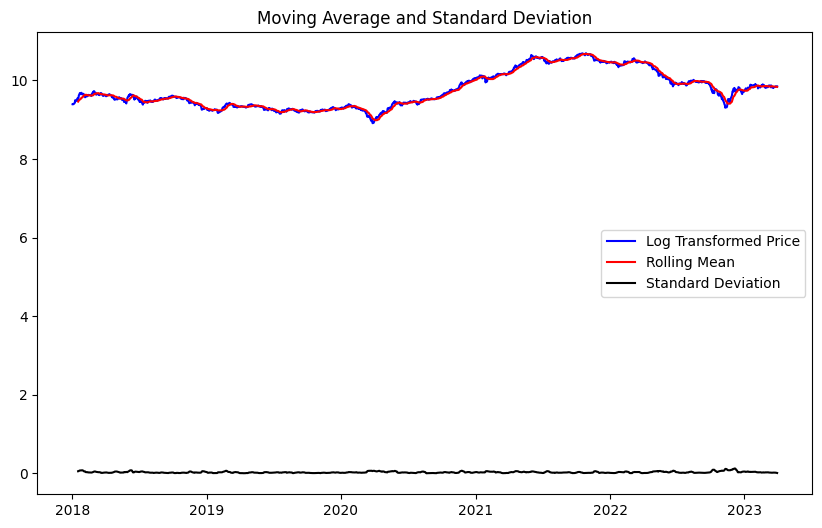

In [ ]:
rcParams['figure.figsize'] = 10, 6

# Log transform the 'Price' column
df_log = np.log(df['Price'])

# Calculate rolling mean and standard deviation
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_log, color='blue', label='Log Transformed Price')
plt.plot(moving_avg, color='red', label='Rolling Mean')
plt.plot(std_dev, color='black', label='Standard Deviation')
plt.legend(loc='best')
plt.title('Moving Average and Standard Deviation')
plt.show()


The plot reveals a clear upward trend in the log-transformed prices, indicating a non-constant mean over time, a hallmark of non-stationarity. The rolling mean closely tracks this trend, further confirming the presence of non-stationarity. Additionally, the rolling standard deviation fluctuates, suggesting that the variance of the data is not constant, further solidifying the non-stationary nature of the log-transformed stock prices.

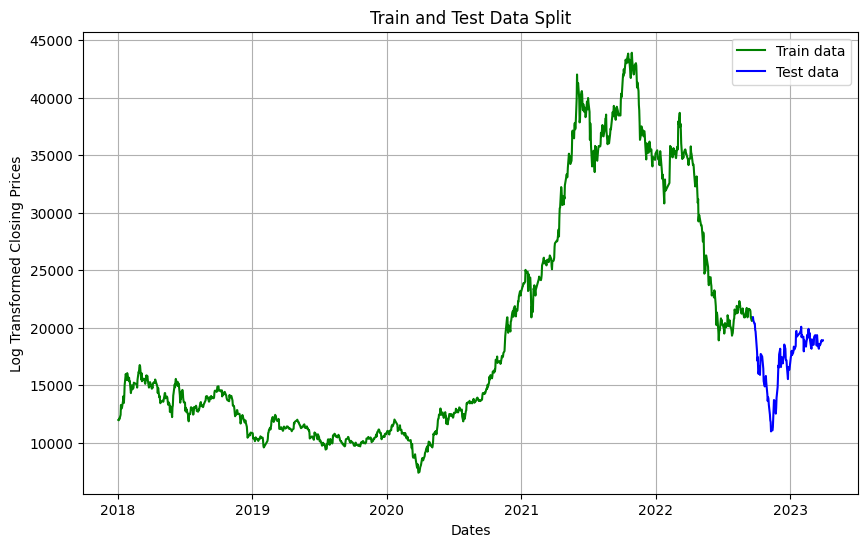

In [ ]:
# Log transform the 'Price' column
df_log = (df['Price'])

# Ensure the 'Date' index is correctly set
df_log.index = df.index

# Split the data into training and testing sets
train_data = df_log[:int(len(df_log) * 0.9)]
test_data = df_log[int(len(df_log) * 0.9):]

# Plot the train and test data
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Log Transformed Closing Prices')
plt.plot(train_data, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()
plt.title('Train and Test Data Split')
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=17881.790, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=17883.384, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17883.346, Time=0.39 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=17880.073, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=17884.818, Time=1.33 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.141 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1177
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8939.036
Date:                Mon, 17 Jun 2024   AIC                          17880.073
Time:                        11:07:21   BIC                          17885.143
Sample:                             0   HQIC                         17881.984
                               - 1177                                  

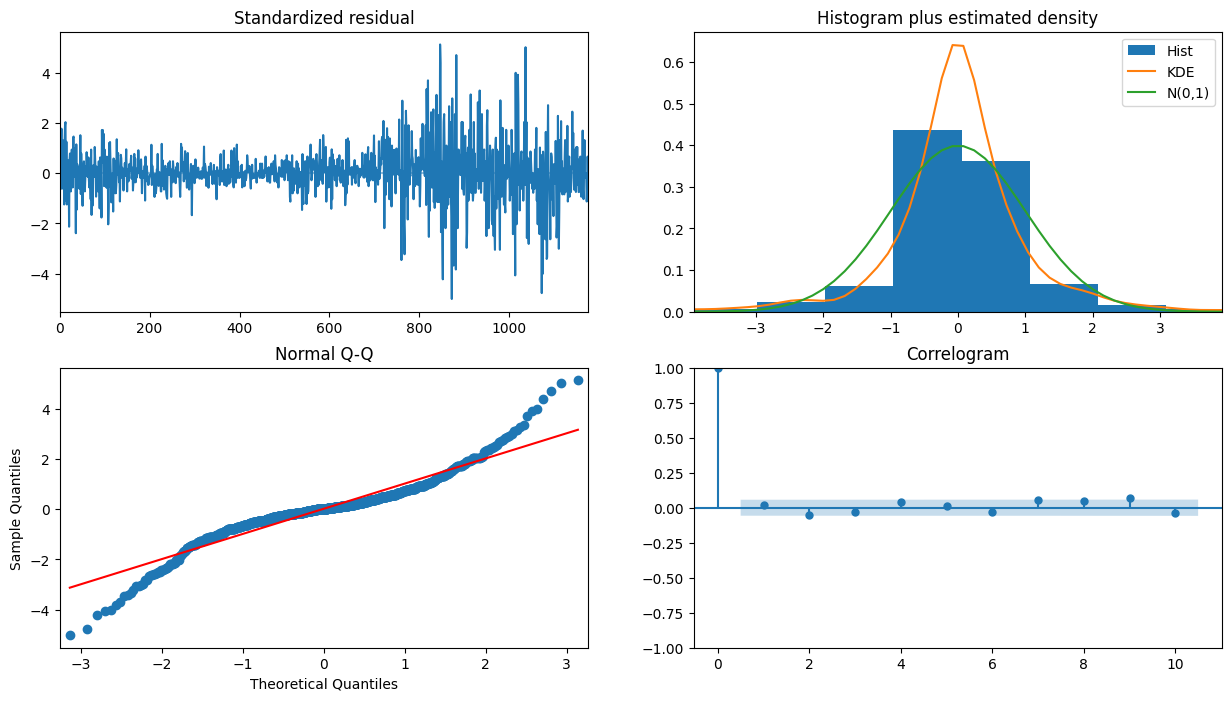

In [ ]:
model = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model.summary())
model.plot_diagnostics(figsize=(15,8))
plt.show()

Diagnostic plots reveal that the residuals are roughly normally distributed with no significant autocorrelation, suggesting a reasonable fit of the model to the data.

In [ ]:
# Create Datafram and format a new set of data
arima_df = data.filter(['Date', 'Price']).copy()
arima_df.index = pd.DatetimeIndex(arima_df).to_period('D')

In [ ]:
# Split the new dataset into 2 parts: For training and for testing
arima_train, arima_test = arima_df[0:len(arima_df)-365] , arima_df[len(arima_df)-365:len(arima_df)]

In [ ]:
# Conduct ADF Test to check the stationary of time series data
adf1 = adfuller(arima_df['Price'], regression='c', maxlag=90)
print('ADF stat: ', adf1[0])
print('P - value: ', adf1[1])

ADF stat:  -1.063752630413638
P - value:  0.7293084413461816


In [ ]:
# Conduct ADF Test 2nd to check the stationary of time series data after differencing
adf2 = adfuller(np.diff(arima_df['Price']), regression='n', maxlag=90)
print('ADF stat: ', adf2[0])
print('P - value: ', adf2[1])

ADF stat:  -7.886067360288662
P - value:  5.97072965252889e-13


In [ ]:
# Initialize history with train_data prices
history = train_data.tolist()

# Initialize predictions list
predictions = []

# Walk-forward validation
for t in range(len(test_data)):
    model = ARIMA(history, order=(0, 1, 0))  # ARIMA(0,1,0) model
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)  # Forecast next step only
    predictions.append(output[0])  # Store the prediction

    # Update history with observed Price from test_data
    obs = test_data.iloc[t]
    history.append(obs)

    print(f'predicted={output[0]:.2f}, expected={obs:.2f}')

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame({'Date': test_data.index, 'Predicted_Price': predictions})
predictions_df.set_index('Date', inplace=True)

predicted=20818.00, expected=20909.00
predicted=20909.00, expected=20636.00
predicted=20636.00, expected=20364.00
predicted=20364.00, expected=20364.00
predicted=20364.00, expected=19818.00
predicted=19818.00, expected=19682.00
predicted=19682.00, expected=19273.00
predicted=19273.00, expected=17955.00
predicted=17955.00, expected=17136.00
predicted=17136.00, expected=17455.00
predicted=17455.00, expected=16364.00
predicted=16364.00, expected=16000.00
predicted=16000.00, expected=16682.00
predicted=16682.00, expected=15909.00
predicted=15909.00, expected=17000.00
predicted=17000.00, expected=17727.00
predicted=17727.00, expected=17682.00
predicted=17682.00, expected=17500.00
predicted=17500.00, expected=17136.00
predicted=17136.00, expected=16727.00
predicted=16727.00, expected=16455.00
predicted=16455.00, expected=15364.00
predicted=15364.00, expected=14909.00
predicted=14909.00, expected=15545.00
predicted=15545.00, expected=15364.00
predicted=15364.00, expected=15818.00
predicted=15

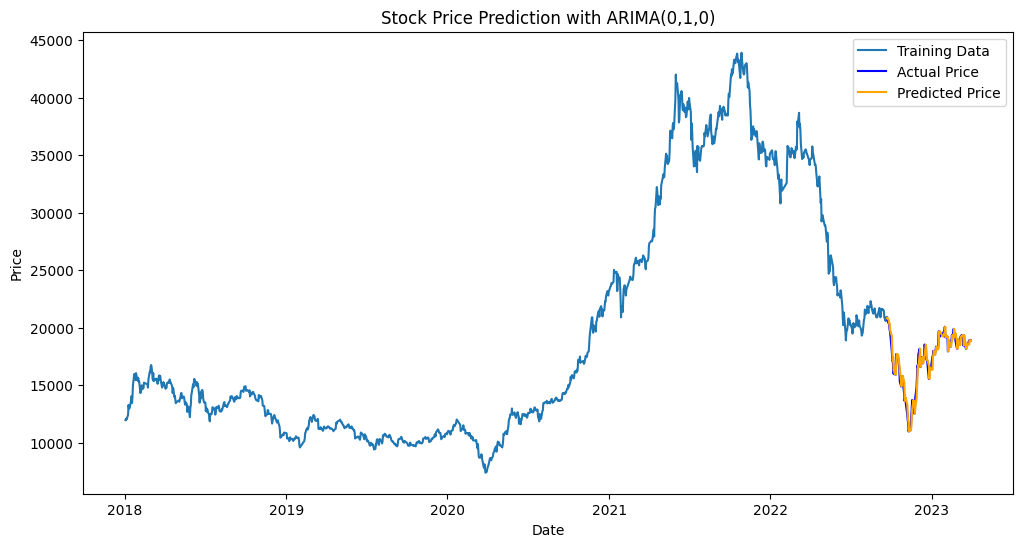

In [ ]:
# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Training Data')
plt.plot(test_data.index, test_data, color='blue', label='Actual Price')
plt.plot(predictions_df.index, predictions_df['Predicted_Price'], color='orange', label='Predicted Price')
plt.fill_between(predictions_df.index, test_data, predictions_df['Predicted_Price'], color='k', alpha=0.1)
plt.title('Stock Price Prediction with ARIMA(0,1,0)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

def calculate_metrics(y_true, y_pred):
    # Calculate R-squared
    r_squared = r2_score(y_true, y_pred)

    # Calculate MAPE
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))

    # Create metrics DataFrame
    metrics_df = pd.DataFrame({
        'R-squared': [r_squared],
        'MAPE': [mape],
        'RMSE': [rmse]
    }, index=['ARIMA'])

    return metrics_df

# Example usage with your ARIMA predictions and test_data
metrics_df = calculate_metrics(test_data, predictions)

# Print the metrics DataFrame
print(metrics_df)


       R-squared      MAPE        RMSE
ARIMA   0.939856  2.692478  566.338238


## 3.2. LSTM Model

## Model Preprocessing


The model is preprocessed in these particular steps:
* Create a copy of the original data
* Sort the data by `Date` for easy appending and splitting operations later on
* Select only the `Date` and `Price` columns as these are the columns we are interested in predicting
* Converting the DataFrame into a numpy array to fit within the LSTM model

In [ ]:
data = pd.read_excel('/content/drive/MyDrive/[H4TF Miền Bắc 2024] Workspace/Submission/CleanedDataset.xlsx')

In [ ]:
# Creating a copy of the original data
HPG = data.copy()

# Sort the data by Date
HPG = HPG.sort_values(by=['Date'])

# Filter out only 'Date' and 'Price' columns
HPG_subset = HPG[['Price']]

# Convert the DataFrame to a numpy array
HPG_LSTM = HPG_subset.filter(['Price']).values

# Check the data for correct coding
HPG_subset.head()

,Price
1307,11991.0
1306,11965.9
1305,12116.7
1304,12066.4
1303,12443.5


As we are interested in building a model that can predict stock prices even in the circumstance that extreme external conditions are affecting the dataset, we decide to keep the last 365 days to use as the test dataset. This number will only take up 27.9% of the dataset which is acceptable. Furthermore, the last year within this dataset has witness extreme changes in stock price. That is why we want to use the last year as testing data.

In [ ]:
# Calculating the number of rows remaining after subtracting the last 365 rows for testing
training_data_len = int(np.ceil( len(HPG_LSTM) - 365 ))

training_data_len

943

In [ ]:
# Data scaling with MinMaxScaler()
MMS = MinMaxScaler()
scaled_data = MMS.fit_transform(HPG_LSTM)
scaled_data

array([[0.12551255],
       [0.12482458],
       [0.1289579 ],
       ...,
       [0.31512992],
       [0.31512992],
       [0.31512992]])

In [ ]:
# Create the training dataset previously scaled
train_data = scaled_data[0:int(training_data_len), :]
train_data

array([[0.12551255],
       [0.12482458],
       [0.1289579 ],
       [0.12757921],
       [0.13791525],
       [0.16134196],
       [0.15307258],
       [0.15307258],
       [0.15582995],
       [0.17305668],
       [0.18270201],
       [0.16616599],
       [0.18270201],
       [0.20819537],
       [0.23506743],
       [0.22059807],
       [0.23713409],
       [0.22059807],
       [0.21921938],
       [0.22611008],
       [0.21715272],
       [0.21784344],
       [0.1895927 ],
       [0.19648339],
       [0.20681669],
       [0.20819537],
       [0.19855005],
       [0.2019954 ],
       [0.21439809],
       [0.21026203],
       [0.20268337],
       [0.22128604],
       [0.24057943],
       [0.23851277],
       [0.25160344],
       [0.25642748],
       [0.25367284],
       [0.22197676],
       [0.23713409],
       [0.21784344],
       [0.22266473],
       [0.22059807],
       [0.22404342],
       [0.22059807],
       [0.22266473],
       [0.21439809],
       [0.21164072],
       [0.231

The data will then be split into `x_train` and `y_train` with the idea that for any values $i$ in `y_train`, the model will use values from $i - 1$ to $i - size$ to predict that particular value, or a sliding window approach.

The team has tried various `size` values (30, 60, 90, etc) and found that 15 days work best. The reason is becase of the large fluctuations of stock price due to events such as the COVID-19 or various wars across the globe. Because of that, looking to far into the past yields little value for the model.

The data is then converted into numpy arrays and reshaped to fit into the LSTM model.

In [ ]:
# Spliting the train data into x_train and y_train
x_train = []
y_train = []
size = 15

for i in range(size, len(train_data)):
    x_train.append(train_data[i-size:i, 0])
    y_train.append(train_data[i, 0])

# Convert training data into numpy arrays to fit into the model
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(928, 15, 1)

## Model Training


We have tuned the data based on multiple rounds of trial and errors and we have decided on these hyperparameters:
* 2 layers model: The data is complex instead of exihibiting a stable trend so we will need 2 layers instead of 1.the
* `batch_size = 32`: This is generally considered  default value for `batch_size`.
* `optimizer = 'adam'`: `adam` is a well-known and widely used optimizer.
* `loss = 'mean_squared_error'`: This is used as MRSE is one of the criteria required by Business Case to evaluate the two models

In [ ]:
# LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model based on decided optimizer and loss function
model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/50
29/29 [==============================] - 6s 56ms/step - loss: 0.0165
Epoch 2/50
29/29 [==============================] - 2s 57ms/step - loss: 9.0830e-04
Epoch 3/50
29/29 [==============================] - 1s 50ms/step - loss: 6.1476e-04
Epoch 4/50
29/29 [==============================] - 2s 68ms/step - loss: 5.5949e-04
Epoch 5/50
29/29 [==============================] - 1s 29ms/step - loss: 5.4553e-04
Epoch 6/50
29/29 [==============================] - 1s 31ms/step - loss: 5.6376e-04
Epoch 7/50
29/29 [==============================] - 1s 32ms/step - loss: 5.8997e-04
Epoch 8/50
29/29 [==============================] - 1s 33ms/step - loss: 5.6523e-04
Epoch 9/50
29/29 [==============================] - 1s 32ms/step - loss: 5.3224e-04
Epoch 10/50
29/29 [==============================] - 1s 32ms/step - loss: 5.2863e-04
Epoch 11/50
29/29 [==============================] - 1s 32ms/step - loss: 4.9601e-04
Epoch 12/50
29/29 [==============================] - 1s 30ms/step - loss: 6.52

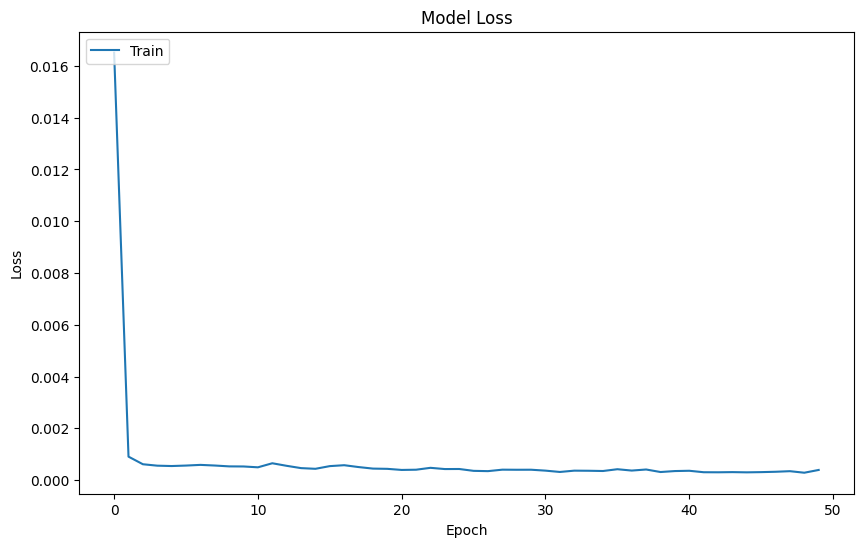

In [ ]:
plt.plot(model.fit(x_train, y_train, batch_size=32, epochs=20).history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
# Train the model based on decided hyperparameters
model.fit(x_train, y_train, batch_size=20, epochs=50)

Epoch 1/50
29/29 [==============================] - 1s 28ms/step - loss: 4.7322e-04
Epoch 2/50
29/29 [==============================] - 1s 34ms/step - loss: 3.4555e-04
Epoch 3/50
29/29 [==============================] - 1s 32ms/step - loss: 2.8222e-04
Epoch 4/50
29/29 [==============================] - 1s 32ms/step - loss: 3.0095e-04
Epoch 5/50
29/29 [==============================] - 1s 29ms/step - loss: 2.8287e-04
Epoch 6/50
29/29 [==============================] - 1s 29ms/step - loss: 2.5672e-04
Epoch 7/50
29/29 [==============================] - 1s 29ms/step - loss: 2.4567e-04
Epoch 8/50
29/29 [==============================] - 1s 30ms/step - loss: 2.8070e-04
Epoch 9/50
29/29 [==============================] - 2s 53ms/step - loss: 3.1593e-04
Epoch 10/50
29/29 [==============================] - 1s 52ms/step - loss: 2.3514e-04
Epoch 11/50
29/29 [==============================] - 2s 54ms/step - loss: 2.6341e-04
Epoch 12/50
29/29 [==============================] - 2s 58ms/step - loss: 

### Model Testing

The test dataset is extracted and processed in a similar fashion as the traning


In [ ]:
# Create the test dataset
test_data = scaled_data[training_data_len - size: , :]

# Split the data sets x_test and y_test with similar ideas to the train dataset
x_test = []
y_test = HPG_LSTM[training_data_len:, :]
for i in range(size, len(test_data)):
    x_test.append(test_data[i-size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Predicted values of the model
predictions = model.predict(x_test)
predictions = MMS.inverse_transform(predictions)

12/12 [==============================] - 1s 20ms/step


### Model Evaluation

As requested by the Business Case 1 prompt, this model will be evaluated based on 3 metricsL: R-squared, MAPE, and RMSE. The team has calculated these values for this model.

In [ ]:
# Calculate R-squared
r_squared = r2_score(y_test, predictions)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return str(np.mean(np.abs((y_true - y_pred) / y_true)) * 100) + "%"

# Calculate RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))

# Merge results into a DataFrame
LSTM_metrics = pd.DataFrame({
    'R-squared': [r_squared],
    'MAPE': [mean_absolute_percentage_error(y_test, predictions)],
    'RMSE': [rmse]
}, index = ['LSTM'])

LSTM_metrics

,R-squared,MAPE,RMSE
LSTM,0.99444,2.120120548115634%,657.259575


### Results Visualization

To better understand LSTM results, the team decided to plot the predictions. Visually, the predictions are very accurate event within extreme price swings in 2022 and 2023. Therefore the model has successfully complete its goal of predicting stock prices even within extreme events.

In [ ]:
# Ensure 'Date' is a datetime column
HPG['Date'] = pd.to_datetime(HPG['Date'])

# Create the training data used for plotting
viz_train = HPG[:training_data_len].copy()
viz_train.set_index('Date', inplace=True)

# Create the testing and predictions data used for plotting
viz_test = HPG[training_data_len:].copy()
viz_test.set_index('Date', inplace=True)
viz_test.insert(1, 'Predictions', predictions, True)

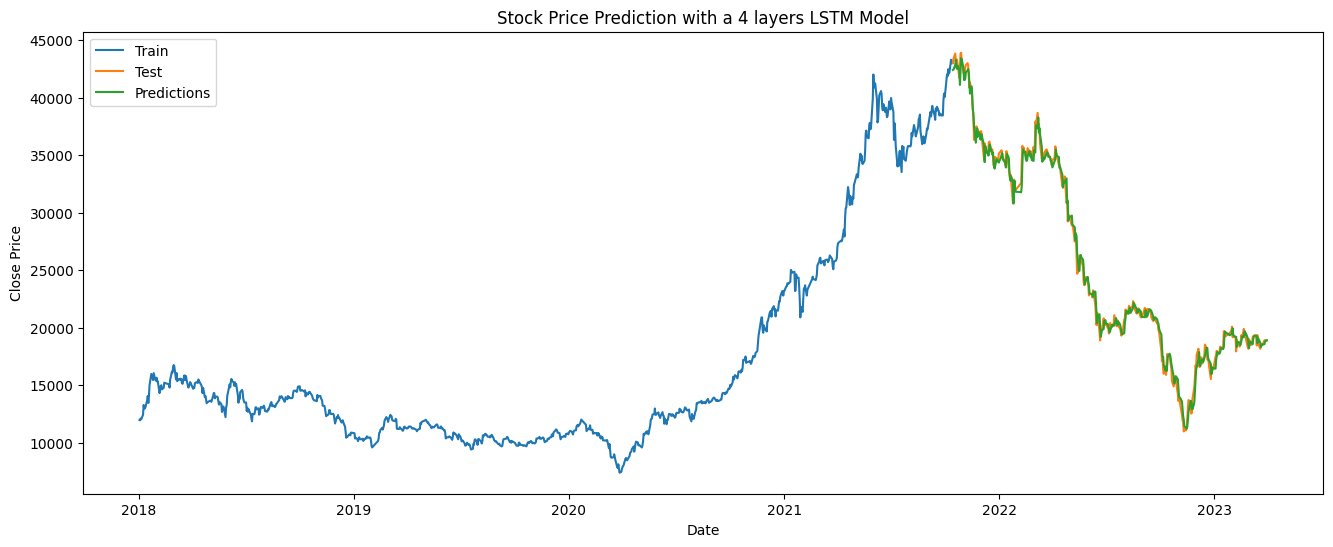

In [ ]:
# Line Chart
plt.figure(figsize=(16,6))
plt.title('Stock Price Prediction with a 4 layers LSTM Model')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(viz_train.index, viz_train['Price'])
plt.plot(viz_test.index, viz_test[['Price', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='upper left')
plt.show()

In [ ]:
combined_metrics = pd.concat([metrics_df, LSTM_metrics])

print("Models' Metrics Comparison:")
print(combined_metrics)

Models' Metrics Comparison:
       R-squared                MAPE        RMSE
ARIMA   0.939856            2.692478  566.338238
LSTM    0.994440  2.120120548115634%  657.259575
